In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from catboost import CatBoostRegressor

# 4. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

## Загрузка данных

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
# TRAIN_DATASET_PATH = '/kaggle/input/realestatepriceprediction/train.csv'
# TEST_DATASET_PATH = '/kaggle/input/realestatepriceprediction/test.csv'

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
X_final = pd.read_csv(TEST_DATASET_PATH)

In [4]:
df.set_index('Id', inplace=True)

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)

## Анализ данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaf5cb0640>,
      dtype=object)

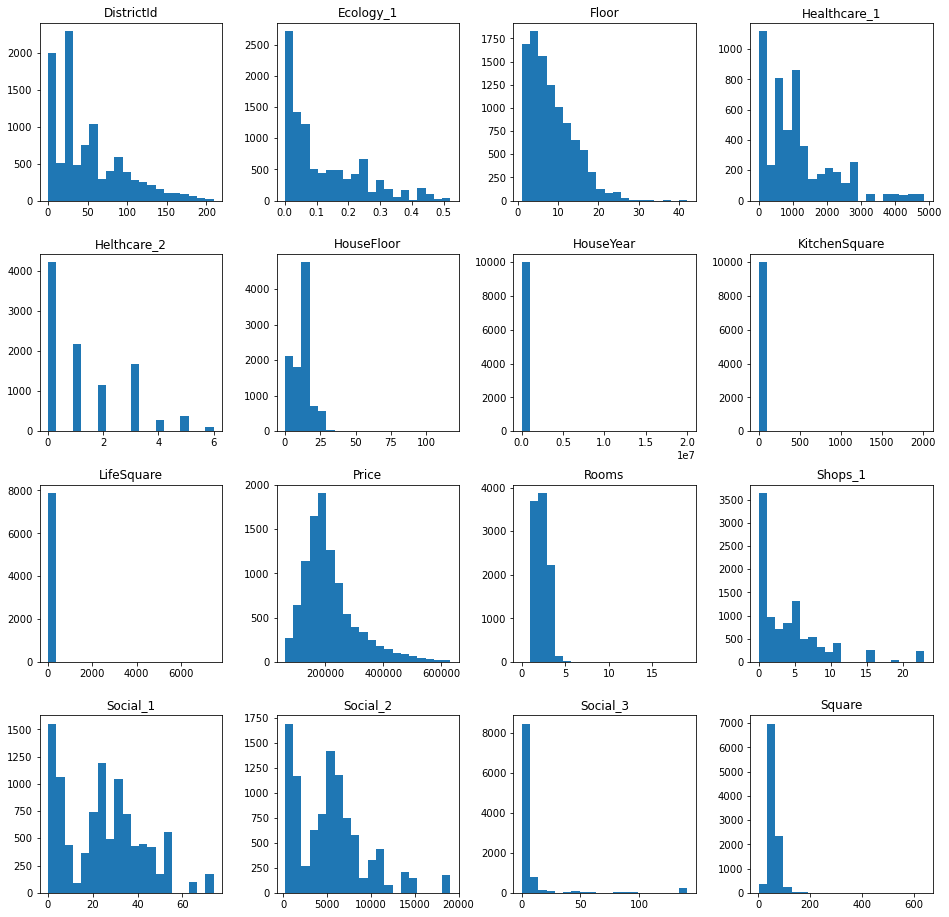

In [5]:
df.hist(figsize=(16,16), bins=20, grid=False)

Видим, что есть выбросы по Rooms, Square, LifeSquare, KitchenSquare, HouseYear. Разберем эти фичи отдельно. Также отметим, что выбросы присутствуют в Social_3

### Rooms

In [6]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Видим что есть выбросы по комнатам в значениях > 5 и 0, будем исправлять

### Square, LifeSquare

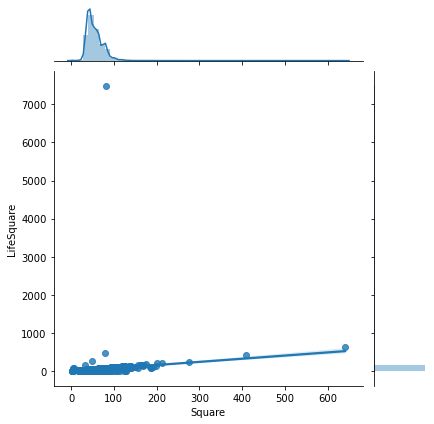

In [7]:
grid = sns.jointplot(df.Square, df.LifeSquare, kind='reg')

В Square и LifeSquare тоже присутствуют выбросы. Выберем значения Square < 300 и LifeSquare < 1000

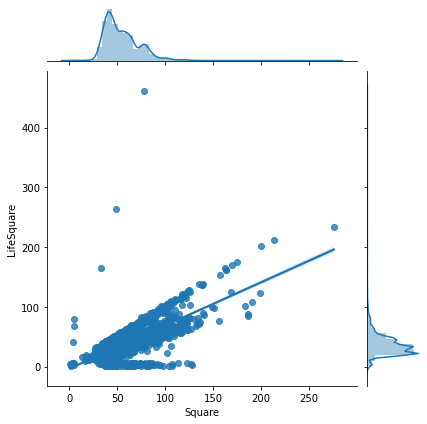

In [8]:
df_temp = df.loc[(df.Square < 300) & (df.LifeSquare < 1000)]
grid = sns.jointplot(df_temp.Square, df_temp.LifeSquare, kind='reg')

Значения Square < 300 и LifeSquare < 250 будем считать выбросами

### KitchenSquare

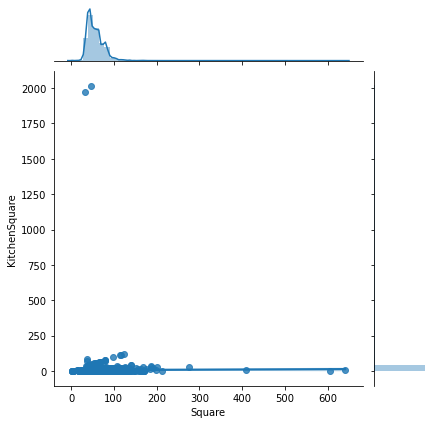

In [9]:
grid = sns.jointplot(df.Square, df.KitchenSquare, kind='reg')

Значения KitchenSquare > 250 будем считать выбросами. Также сложно представить кухню < 5 квадратных метров

### HouseYear

In [10]:
# HouseYear
df[df.HouseYear > 2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


Год 4968 похоже на опечатку, заменим его 1968. Год 20052011 - средним между 2005 и 2001

### Floor, HouseFloor

In [11]:
df.HouseFloor.sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

Отметим, что имеются нулевые значения. Заполним их медианными

In [12]:
(df.Floor > df.HouseFloor).sum()

1825

Также имеются записи, где этаж больше этажности дома. Исправим их

# Очистка данных

In [13]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def fill_rooms_by_id_list(self, df, idx_list):
        for idx in idx_list:
            did = int(df[df.index == idx].DistrictId)
            curr_square = float(df[df.index == idx].Square)
            # смотрим в пределах площади +- 10%
            l_from = curr_square - (curr_square * 0.10)
            l_to = curr_square + (curr_square * 0.10)
            nr = df[(df.Square > l_from) & (df.Square < l_to) & (df.DistrictId == did)].Rooms.median()
            df.loc[df.index == idx, 'Rooms'] = nr
            df.loc[df.index == idx, 'Rooms_outlier'] = 1
        
    def transform_train(self, df):
        
        # В начале, исправим аномально большой Square/LifeSquare:
        # мы знаем что у id 3224 аномальный square/lifesquare. исправим вручную
        tmp_df = df[(df.DistrictId == 27) & (df.Price > 120596) & (df.Price < 130596) & (df.HouseYear == 1977) & (df.Social_2 == 469)] 
        df.loc[df.index == 3224, 'Square'] = tmp_df.Square.median()
        df.loc[df.index == 3224, 'LifeSquare'] = tmp_df.LifeSquare.median()

        df['Square_outlier'] = 0
        df['LifeSquare_outlier'] = 0
        df.loc[df.index == 3224, 'Square_outlier'] = 1
        df.loc[df.index == 3224, 'LifeSquare_outlier'] = 1
        
        # Rooms
        df['Rooms_outlier'] = 0
        room_ids = list(df[df.Rooms.isin([6, 19, 10, 0])].index)
        self.fill_rooms_by_id_list(df, room_ids)
        # эти заполняем вручную, так как подобных квартир - мало (довольно большие площади)
        df.loc[df.index == 12638, 'Rooms'] = 3
        df.loc[df.index == 7917, 'Rooms'] = 4
        df.loc[df.index == 12638, 'Rooms_outlier'] = 1
        df.loc[df.index == 7917, 'Rooms_outlier'] = 1
        
        # df[df.Square > 400]
        # просматривая подобные записи (где совпадает DistrictId и иногда иные фичи)
        # приходим к выводу, что ошибка площади квартиры - в порядке. Делим эти площади на 10
        idx_list = df[df.Square > 400].index
        for idx in idx_list:
            df.loc[df.index == idx, 'Square'] = float(df[df.index == idx].Square) / 10
            df.loc[df.index == idx, 'Square_outlier'] = 1
            df.loc[df.index == idx, 'LifeSquare'] = float(df[df.index == idx].LifeSquare) / 10
            df.loc[df.index == idx, 'LifeSquare_outlier'] = 1
            
        # просматриваем и меняем еще пару записей:
        tmp_df = df[(df.DistrictId == 27) & (df.Rooms == 3) & (df.Price > 217357-5000) & (df.Price < 217357+5000) & (df.HouseYear > 2010)]
        df.loc[df.index == 16550, 'LifeSquare'] = float(tmp_df.LifeSquare.median())
        df.loc[df.index == 16550, 'LifeSquare_outlier'] = 1
        df.loc[df.index == 15886, 'LifeSquare'] = float(df[df.index == 15886].LifeSquare / 10)
        df.loc[df.index == 15886, 'LifeSquare_outlier'] = 1

        return df

    def transform_test(self, df):
        
        df['Square_outlier'] = 0
        df['LifeSquare_outlier'] = 0
        df.loc[df.index == 11533, 'LifeSquare'] = df.loc[df.index == 11533].LifeSquare / 10
        df.loc[df.index == 11533, 'LifeSquare_outlier'] = 1

        df['Rooms_outlier'] = 0
        # эти заполняем вручную, так как подобных квартир - мало (довольно большие площади)
        df.loc[df.index == 1435, 'Rooms'] = 2
        df.loc[df.index == 1435, 'Rooms_outlier'] = 1
        df.loc[df.index == 3343, 'Rooms'] = 3
        df.loc[df.index == 3343, 'Rooms_outlier'] = 1

        df.loc[df.index == 10729, 'Rooms'] = 2
        df.loc[df.index == 10729, 'Rooms_outlier'] = 1

        return df


    def transform(self, df, min_num_of_records, max_nan_percent):
        
        # lifesquare_med_percent - медианное значение (все квартиры такого же района с таким же
        # количеством комнат) процента жилой площади в общей площади квартиры.
        # Заполним значения lifesquare_med_percent, сгруппировав значения по району и по кол-ву комнат.
        # Причем в определенном районе с определенным количеством комнат должно присутствовать
        # минимум записей LifeSquare в количестве min_num_of_records
        # а также процент таких записей от общего количества записей (с данным количеством комнат в данном
        # районе) не должен привышать значения max_nan_percent
    
        d1 = df[df.LifeSquare.isna()].groupby(["DistrictId", "Rooms"]).size().reset_index(name="count_nan")
        d2 = df.groupby(["DistrictId", "Rooms"]).size().reset_index(name="count_total")
        d3 = pd.merge(d1, d2, on=["DistrictId", "Rooms"])
        d3['nan_percent'] = (d3.count_nan * 100) / d3.count_total
        d3['did_room']=(d3.DistrictId * 100) + d3.Rooms
        d_res = d3[(d3.count_total > min_num_of_records) & (d3.nan_percent < max_nan_percent)]
        dids_rooms = d_res.did_room.unique()
        df['did_room']=(df.DistrictId * 100) + df.Rooms
        cond = df.did_room.isin(dids_rooms)
        df.loc[cond, 'lifesquare_percent'] = (df.loc[cond, 'LifeSquare'] * 100) / df.loc[cond, 'Square']
        dftemp = df[df.did_room.isin(dids_rooms)]
        df_med_percent = pd.DataFrame(dftemp.groupby(["DistrictId","Rooms"])['lifesquare_percent'].median())
        df_med_percent.reset_index(inplace=True)
        df_med_percent.rename(columns={'lifesquare_percent': 'lifesquare_med_percent'}, inplace=True)
        df_med_percent['did_room']=(df_med_percent.DistrictId * 100) + df_med_percent.Rooms
        df_med_percent.drop(['DistrictId', 'Rooms'], axis=1, inplace=True)

        df.reset_index(inplace=True)
        df = pd.merge(df, df_med_percent, how='left', on='did_room')
        df.set_index('Id', inplace=True)
        
        df.loc[df.LifeSquare.isna(), 'LifeSquare_outlier'] = 1
        df.LifeSquare.fillna(df.lifesquare_med_percent, inplace=True)

        # оставшиеся LifeSquare заполним медианными значениями
        df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].median())
        
        #HouseYear
        df.loc[df.HouseYear == 20052011, 'HouseYear'] = 2008 # среднее
        df.loc[df.HouseYear == 4968, 'HouseYear'] = 1968
        
        # удалим, так как слишком много пропусков и мало влияет на результат
        df.drop(['Healthcare_1'], axis=1, inplace=True)

        # удалим, так как плохо влияют на результат
        droplist = ['lifesquare_med_percent', 'lifesquare_percent', 'did_room']
        df.drop(droplist, axis=1, inplace=True)

        # KitchenSquare
        df.loc[df.KitchenSquare < 5, 'KitchenSquare'] = 5
        df.loc[df.KitchenSquare > 250, 'KitchenSquare'] = df.KitchenSquare.median()

        # HouseFloor, Floor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']
        
        return df


In [14]:
imputer = FeatureImputer()

In [15]:
imputer.fit(df)

In [16]:
df = imputer.transform_train(df)
df = imputer.transform(df, 30, 70)

X_final = imputer.transform_test(X_final)
X_final = imputer.transform(X_final, 30, 70)

In [17]:
X = df.drop('Price', axis=1)
y = df['Price']

In [18]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            ## По сравнению с baseline добавим District, year
            self.med_price_by_district_year = df.groupby(['DistrictId_popular', 'HouseYear'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrictYear'})

            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        


        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1993), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1993) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            

In [19]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [20]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [21]:
# CatBoostRegressor дал мне наилучший результат.
# learning_rate, iterations, depth подобрал с помощью RandomizedSearchCV
model = CatBoostRegressor( # R2: 0.761 +- 0.019 - kaggle score: 0.76097  pred-catboost-04v2.csv
    silent=True,
    learning_rate=0.0437,
    iterations=1196,
    eval_metric='R2',
    depth=6
)

In [22]:
model.fit(X, y)

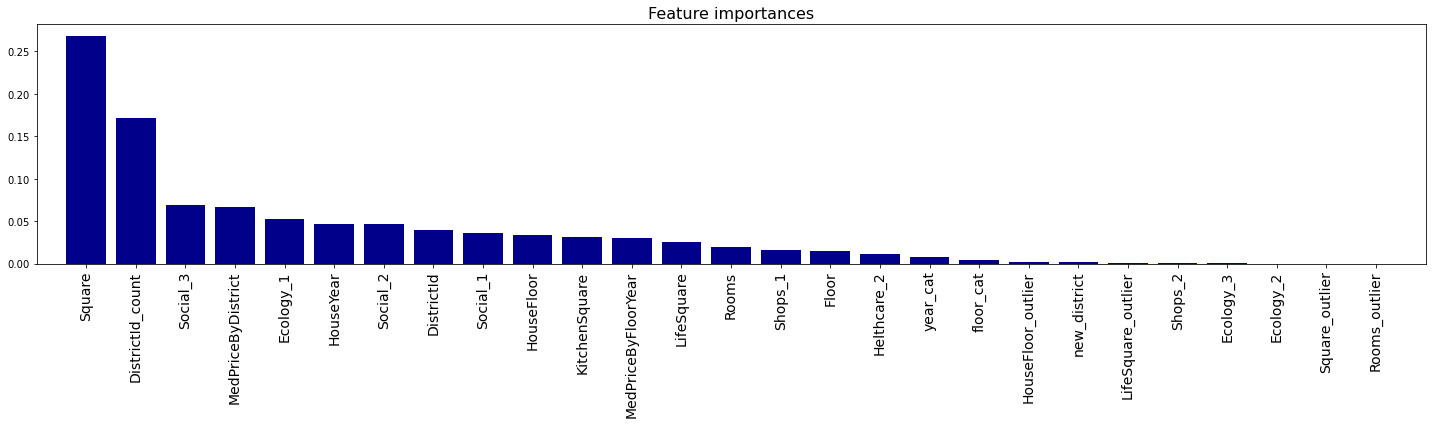

In [23]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [24]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False) # pred-catboost-04v2.csv

preds_final.head()

,Id,Price
0,725,146913.668936
1,15856,222545.463426
2,5480,216819.788813
3,15664,343853.422003
4,14275,142241.828286


In [25]:
preds_final.shape

(5000, 2)

In [26]:
cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))
print(f'R2: {cv_score.mean()}')

R2: 0.761 +- 0.019
R2: 0.7610974260377361


In [27]:
# kaggle score: 0.76097